In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 100,

    # saving settings for latex
    # https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
    # "pgf.texsystem": "pdflatex",
    # "font.family": "serif",
    # "text.usetex": True,
    # "pgf.rcfonts": False,
    })

%matplotlib inline

In [5]:
# load the dataset without the target feature
df = pd.read_csv("./data/cad/data_feat.csv", index_col=0, decimal='.')
df = df.iloc[:, :-1]
# df.info()

### 1- Feature Clustering Using Correlation Matrix

In [6]:
corr = df.corr(method='pearson').abs()
threshold = 0.3
df_cluster = pd.DataFrame()

# for each column we sort the column's and get the top correlated columns by setting a threshold,
# and save the result in a df
for col_name in corr.columns:
    corr_col = corr[col_name].sort_values(ascending=False)
    corr_col = corr_col[corr_col >= threshold]
    
    corr_series = pd.DataFrame([",".join(corr_col.index.values)], index=[col_name], columns=["correlated_columns"])
    df_cluster = df_cluster.append(corr_series)
    # print(corr_series.index.values[0])
    # print(corr_series.values[0][0])
    # print("\n")

# df_cluster.to_csv(f"data/data/features_clustering/feat_cluster_{threshold}.csv")
df_cluster.head()

,correlated_columns
Gender (Male = 1),Gender (Male = 1)
Age,Age
Angina,"Angina,Documented resting \nor exertional isch..."
Previous CABG,Previous CABG
Previous PCI,Previous PCI


Correlation (>= 0.3) size: 63.0 / 3080


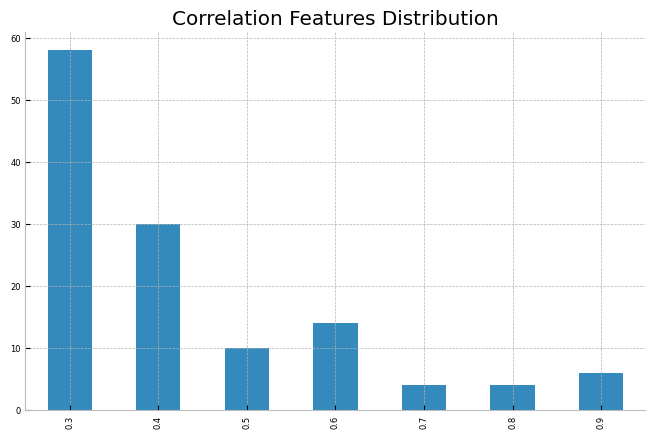

In [87]:
corr1D = pd.Series(corr.values.flatten())
corr1D = corr1D[corr1D != 1]
corr1D = corr1D.map(lambda x: round(x, 1))
corr_dist = corr1D.value_counts().sort_index()
corr_dist = corr_dist[corr_dist.index >= threshold]
corr_dist.plot(kind="bar", fontsize=6)
plt.title("Correlation Features Distribution")

print(f"Correlation (>= {threshold}) size: {corr_dist[corr_dist.index >= threshold].sum()/2} / {len(corr1D/2)}")

### 2- Feature Clustering Using Correlation Matrix + Hierarchical Clustering
[Clustering using a matrix of correlation coeff](https://stackoverflow.com/questions/38070478/how-to-do-clustering-using-the-matrix-of-correlation-coefficients)

[S v P](https://stats.stackexchange.com/questions/8071/how-to-choose-between-pearson-and-spearman-correlatio) considerations
- Spearman checks only the monotonic relationships (less assumptions, more resistant to outliers)
- Pearson checks the linear relationships

Number of clusters: 7


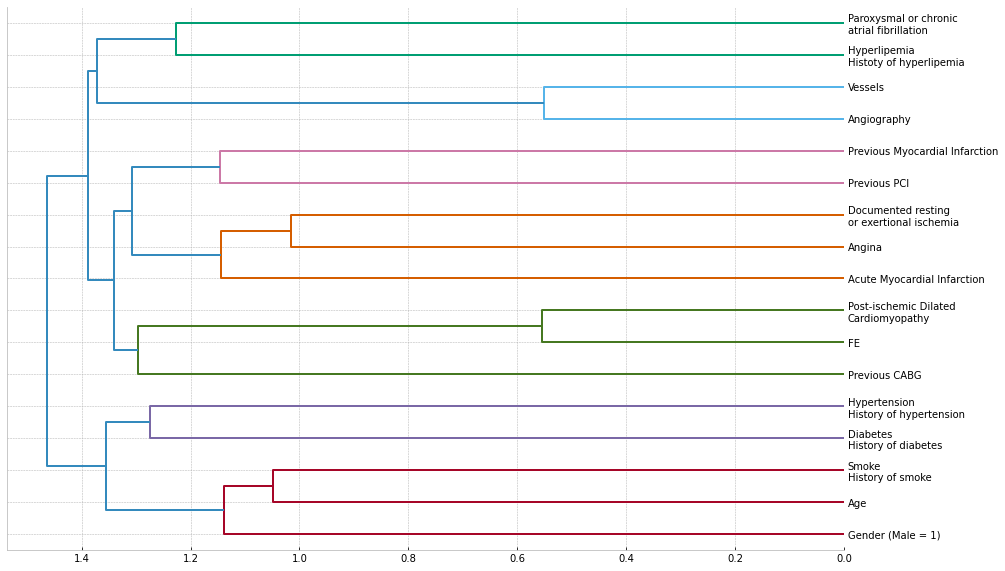

In [27]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

# 1) compute the correlation (similarity) and distance (dissimilarity)
corr = df.corr(method="spearman")  
dist = 1 - corr.abs()

# 2) transform the distance matrix into a condensed distance vector
dist_condense = pdist(dist)

# 3) create the hierarchical clustering using the condensend distance vector
hier = hierarchy.linkage(dist_condense, method="weighted")
threshold = 1.3
# threshold = 1.5
cluster_labels = hierarchy.fcluster(hier, threshold, criterion="distance")
print(f"Number of clusters: {len(set(cluster_labels))}")

# plot
# choose threshold using dendrogram or any other method (e.g. quantile or desired number of features)
plt.figure(figsize=(15,10))
# plt.title("Hierarchy Clustering of Features")
dend = hierarchy.dendrogram(hier, truncate_mode="level", p=30, color_threshold=threshold, 
                     labels=corr.columns, orientation="left", leaf_font_size=10)

In [28]:
# save each group feature
df_cluster = pd.DataFrame({'ClusterID': cluster_labels,
                           'Feature': df.columns})
df_cluster = df_cluster.groupby(['ClusterID'])
df_cluster = df_cluster['Feature'].apply(lambda x: list(x)).reset_index()['Feature']
df_cluster.to_pickle('data/cad/feat_cluster_hier.df')
df_cluster

0    [Gender (Male = 1), Age, Smoke\nHistory of smoke]
1    [Diabetes\nHistory of diabetes, Hypertension\n...
2    [Previous CABG, FE, Post-ischemic Dilated\nCar...
3    [Angina, Acute Myocardial Infarction, Document...
4       [Previous PCI, Previous Myocardial Infarction]
5                               [Angiography, Vessels]
6    [Hyperlipemia\nHistoty of hyperlipemia, Paroxy...
Name: Feature, dtype: object

In [131]:
# df_test = pd.read_pickle('data/data/features_clustering/feat_cluster_hier.df')

In [22]:
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics import silhouette_score

# cophenet correlation measure how faithfully the dendrogram preserves the original data point's distance
# cophenet = optimal when -> 1
# https://en.wikipedia.org/wiki/Cophenetic_correlation
c, coph_dists = cophenet(hier, pdist(dist))
c

0.8448600280105093

In [24]:
# sns.clustermap(df.corr())
# plt.show()

,Gender (Male = 1),Age,Angina,Previous CABG,Previous PCI,Previous Myocardial Infarction,Acute Myocardial Infarction,Angiography,Vessels,FE,Documented resting \nor exertional ischemia,Post-ischemic Dilated\nCardiomyopathy,Smoke\nHistory of smoke,Diabetes\nHistory of diabetes,Hypertension\nHistory of hypertension,Hyperlipemia\nHistoty of hyperlipemia,Paroxysmal or chronic \natrial fibrillation
Gender (Male = 1),1.000000,-0.186803,0.024662,0.070630,0.031966,0.071183,-0.084525,0.065356,0.089498,-0.050478,0.090495,0.042327,0.245182,-0.019434,-0.093013,0.001734,-0.002420
Age,-0.186803,1.000000,0.003775,0.098803,-0.046048,0.003914,-0.006281,-0.159205,-0.031969,-0.102971,-0.044513,0.071430,-0.275144,0.073460,0.166621,-0.148669,0.213513
Angina,0.024662,0.003775,1.000000,0.092797,0.117925,-0.065649,-0.160288,0.121546,0.151291,0.205408,0.309582,-0.178926,-0.001345,-0.001931,0.069618,0.114814,-0.108462
Previous CABG,0.070630,0.098803,0.092797,1.000000,0.051625,0.154248,-0.103873,-0.229570,-0.017320,-0.188511,0.063631,0.157309,-0.017167,0.069802,0.031046,0.032638,0.086905
Previous PCI,0.031966,-0.046048,0.117925,0.051625,1.000000,0.237422,-0.124590,-0.182673,-0.158875,-0.019422,0.100531,0.033402,0.044449,0.043862,0.017625,0.092291,-0.000156
Previous Myocardial Infarction,0.071183,0.003914,-0.065649,0.154248,0.237422,1.000000,-0.199430,-0.261286,-0.157476,-0.291465,-0.054847,0.194146,0.085305,0.040909,-0.043329,-0.000619,0.031477
Acute Myocardial Infarction,-0.084525,-0.006281,-0.160288,-0.103873,-0.124590,-0.199430,1.000000,0.061871,0.041631,-0.098515,-0.325883,-0.015008,-0.010122,-0.041851,-0.078089,-0.032926,-0.030707
Angiography,0.065356,-0.159205,0.121546,-0.229570,-0.182673,-0.261286,0.061871,1.000000,0.772951,0.260441,0.242979,-0.245480,0.018832,-0.031981,-0.043569,0.116537,-0.204350
Vessels,0.089498,-0.031969,0.151291,-0.017320,-0.158875,-0.157476,0.041631,0.772951,1.000000,0.125088,0.273249,-0.146314,-0.006308,0.068348,0.006941,0.124456,-0.172466
FE,-0.050478,-0.102971,0.205408,-0.188511,-0.019422,-0.291465,-0.098515,0.260441,0.125088,1.000000,0.283088,-0.743721,-0.072794,-0.086963,0.071213,0.166639,-0.160930
